In [1]:
# Step 1: Import Required Libraries

In [2]:
# Import TensorFlow for building and training machine learning models
import tensorflow as tf
# Import layers and models from Keras to define a neural network
from tensorflow.keras import layers, models
# Import matplotlib for visualizing data and results (e.g., training curves, predictions)
import matplotlib.pyplot as plt
# Import TensorFlow Datasets (tfds) to easily load and use datasets
import tensorflow_datasets as tfds
# Import EarlyStopping callback from Keras to stop training if the model stops improving
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Step 2: Load and Split CIFAR-10 Dataset

In [4]:
# Load the CIFAR-10 dataset, splitting it into training and validation sets
# 'train[:80%]' means 80% of the training data will be used for training
# 'train[80%:]' means 20% of the training data will be used for validation
# with_info=True retrieves additional dataset information, such as class labels
# as_supervised=True means the dataset will be returned as (image, label) pairs
(train_ds, val_ds), info = tfds.load('cifar10',
split=['train[:80%]', 'train[80%:]'],
with_info=True,
as_supervised=True)
# 'train_ds' is the training dataset (80% of CIFAR-10 images)
# 'val_ds' is the validation dataset (20% of CIFAR-10 images)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.7TF9AM_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.7TF9AM_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
# Step 3 : Load, Visualize, and Display CIFAR-10 Images

Visualizing images from the training dataset:


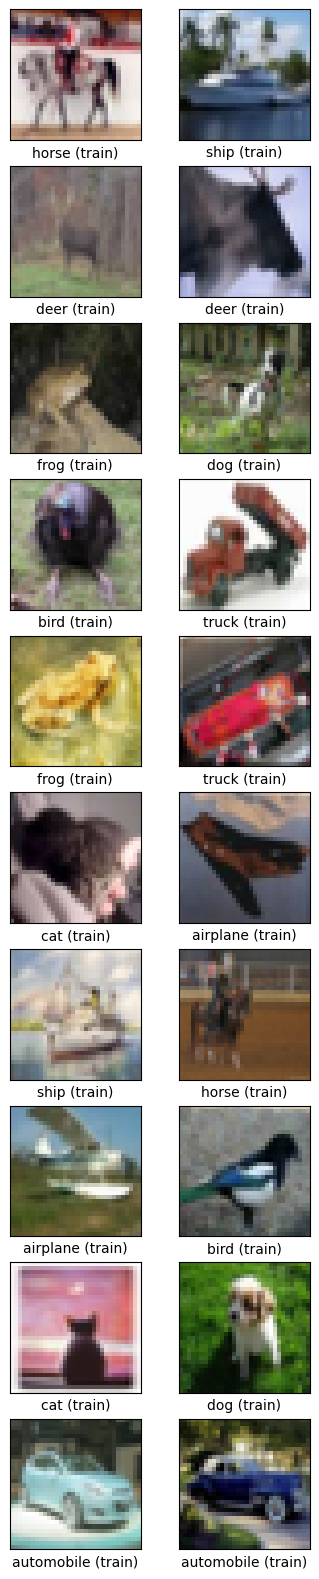

Visualizing images from the test dataset:


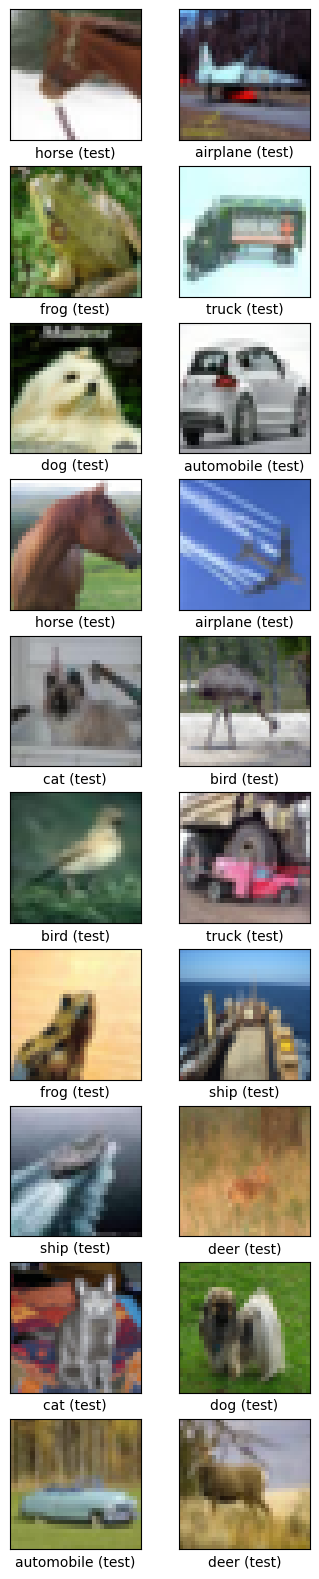

In [6]:
# Import necessary libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np

# TensorFlow for machine learning and dataset handling
# Matplotlib for plotting images
# TensorFlow Datasets to load CIFAR-10
# NumPy for numerical operations

# Load the CIFAR-10 dataset from TensorFlow Datasets
# Split the data into training and test datasets
(train_ds, test_ds), info = tfds.load('cifar10', split=['train', 'test'], with_info=True, as_supervised=True)

# Get the class names from the dataset info
class_names = info.features['label'].names

def display_images(dataset, dataset_type='train', num_images_per_class=2):
    """Displays a grid of images from the dataset."""
    plt.figure(figsize=(num_images_per_class * 2, len(class_names) * 2))
    images_displayed = 0
    class_count = {class_name: 0 for class_name in class_names}

    for image, label in dataset.take(len(class_names) * num_images_per_class * 5): # Take more images to ensure getting enough per class
        # Convert the label (Tensor) to a NumPy value
        label_index = label.numpy()
        class_name = class_names[label_index]  # Get the class name based on the label

        # Display the image if we haven't reached the limit for this class
        if class_count[class_name] < num_images_per_class:
            plt.subplot(len(class_names), num_images_per_class, images_displayed + 1)  # Create a subplot
            plt.xticks([]) # Remove x-axis ticks
            plt.yticks([]) # Remove y-axis ticks
            plt.grid(False) # Disable gridlines
            plt.imshow(image.numpy()) # Display the image
            plt.xlabel(f'{class_name} ({dataset_type})')  # Label the image with its class name and dataset type (train/test)
            class_count[class_name] += 1 # Increment the class count
            images_displayed += 1 # Increment the total images displayed

            # Stop displaying if we have shown enough images
            if images_displayed >= len(class_names) * num_images_per_class:
                break

    plt.show()

# Visualize images from the training set
print("Visualizing images from the training dataset:")
display_images(train_ds, dataset_type='train')

# Visualize images from the test set
print("Visualizing images from the test dataset:")
display_images(test_ds, dataset_type='test')

In [7]:
# Step 4 : Define Data Augmentation and Preprocessing Function

In [8]:
# Define a Sequential model for data augmentation to enhance the dataset
data_augmentation = tf.keras.Sequential([
# Randomly flip the image both horizontally and vertically
layers.RandomFlip("horizontal_and_vertical"),
# Randomly rotate the image by up to 20% (0.2)
layers.RandomRotation(0.2),
# Randomly zoom the image by up to 10% (0.1)
layers.RandomZoom(0.1),
# Add random zoom
# Randomly adjust the contrast of the image (with a factor of 0.2)
layers.RandomContrast(0.2)
# Add random contrast adjustments
])
# Define a preprocessing function that will resize and augment the image, and normalize pixel values
def preprocess_data(image, label):
  # Resize each image to 32x32 pixels to match CIFAR-10 image dimensions
  image = tf.image.resize(image, [32, 32])
  # Apply the defined data augmentation operations (flipping, rotation, zoom, contrast)
  image = data_augmentation(image)
  # Normalize the image pixel values to the range [0, 1]
  image /= 255.0
  return image, label
# Return the processed image and the corresponding label

In [9]:
# Step 5 : Preprocess and Prepare Training and Validation Datasets

In [10]:
# Define the batch size for training
batch_size = 64
# Prepare the training dataset:
# 1. Apply the preprocessing function to each image in the dataset (resize, augment, normalize).
# 2. Shuffle the dataset with a buffer size of 1000 to improve randomness.
# 3. Batch the data into groups of 'batch_size' (64 in this case).
# 4. Prefetch the data for efficient loading during training, using AUTOTUNE for optimal performance.
train_ds = train_ds.map(preprocess_data).shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
# Prepare the validation dataset:
# Similar to the training dataset, but without shuffling or augmentation.
# 1. Apply the preprocessing function to each image.
# 2. Batch the data into 'batch_size' (64).
# 3. Prefetch the data for efficient loading during validation.
val_ds = val_ds.map(preprocess_data).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
# Step 6 : Build the Convolutional Neural Network (CNN) Model

In [12]:
# Define a Sequential model for classification using Conv2D layers (CNN)
model = models.Sequential([
# First convolutional layer: 32 filters, kernel size (3,3), activation function ReLU
layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
# Batch Normalization to normalize the activations from the previous layer
layers.BatchNormalization(),
# Max Pooling layer to down-sample the image (reduces dimensionality, improves efficiency)
layers.MaxPooling2D(pool_size=(2, 2)),
# Second convolutional layer: 64 filters, kernel size (3,3), activation function ReLU
layers.Conv2D(64, (3, 3), activation='relu'),
# Batch Normalization
layers.BatchNormalization(),
# Max Pooling layer
layers.MaxPooling2D(pool_size=(2, 2)),
# Third convolutional layer: 128 filters, kernel size (3,3), activation function ReLU
layers.Conv2D(128, (3, 3), activation='relu'),
# Batch Normalization
layers.BatchNormalization(),
# Max Pooling layer
layers.MaxPooling2D(pool_size=(2, 2)),
# Fourth convolutional layer: 256 filters, kernel size (3,3), padding set to 'same'
layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
# Batch Normalization
layers.BatchNormalization(),
# Max Pooling layer
layers.MaxPooling2D(pool_size=(2, 2)),
# Flatten layer to convert the 2D matrix to a 1D vector for the fully connected layer
layers.Flatten(),
# Fully connected layer with 512 neurons, ReLU activation function
layers.Dense(512, activation='relu'),
# Dropout layer to reduce overfitting, randomly dropping 50% of neurons
layers.Dropout(0.5),
layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Step 7 : Compile the Model

In [14]:
# Compile the model with the following configuration:
# Optimizer: Adam optimizer (commonly used for its adaptive learning rate and efficiency)
model.compile(optimizer='adam',
# Loss function: Sparse Categorical Crossentropy (used for multi-class classification
# with integer labels)
loss='sparse_categorical_crossentropy',
# Metrics: Track accuracy during training and evaluation
metrics=['accuracy'])

In [15]:
# Step 8 : Implement Early Stopping

In [16]:
# Set up EarlyStopping callback to prevent overfitting and stop training early if the validation loss stops improving.
early_stopping = EarlyStopping(
# Monitor the validation loss ('val_loss') to decide when to stop training.
monitor='val_loss',
# Patience: The model will wait for 5 epochs without improvement in 'val_loss' before stopping the training.
patience=5
)

In [17]:
# Step 9 : Train the Model

In [19]:
# Train the model for 30 epochs with the specified training and validation datasets,
# using the early stopping callback to monitor the validation loss and stop early if necessary.
history = model.fit(
# Training dataset
train_ds,
# Validation dataset to evaluate the model after each epoch
validation_data=val_ds,
# Number of epochs to train the model
epochs=30,
# EarlyStopping callback to halt training early if validation loss doesn't improve for 5 epochs
callbacks=[early_stopping]
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 105ms/step - accuracy: 0.5125 - loss: 1.3749 - val_accuracy: 0.5482 - val_loss: 1.2433
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 72s 91ms/step - accuracy: 0.5376 - loss: 1.3194 - val_accuracy: 0.4138 - val_loss: 1.7419
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 70s 89ms/step - accuracy: 0.5455 - loss: 1.2883 - val_accuracy: 0.5394 - val_loss: 1.3084
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 89ms/step - accuracy: 0.5626 - loss: 1.2514 - val_accuracy: 0.5448 - val_loss: 1.2794
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.5712 - loss: 1.2212 - val_accuracy: 0.5427 - val_loss: 1.2920
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 73s 90ms/step - accuracy: 0.5803 - loss: 1.2036 - val_accuracy: 0.5875 - val_loss: 1.1730
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 71s 89ms/step - accuracy: 0.5939 - loss: 1.1635 - val_accuracy: 0.5959 - val_loss: 1.1451
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 75s 95ms/step - accuracy: 0.5984 - loss: 1.1489 

In [20]:
# Step 10 : Save the Trained Model

In [21]:
# Save the trained model to a file for later use, so you can load it without retraining.
model.save('cifar10_model.h5')

In [22]:
# Step 11 : Evaluate the Model on the Validation Dataset

In [23]:
# Evaluate the trained model on the validation dataset to assess its performance.
loss, accuracy = model.evaluate(val_ds)
# Print the validation accuracy to see how well the model performs on unseen data.
print(f'Validation accuracy: {accuracy:.2f}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 97ms/step - accuracy: 0.6937 - loss: 0.8781
Validation accuracy: 0.69


In [24]:
# Step 12 : Visualize Training History

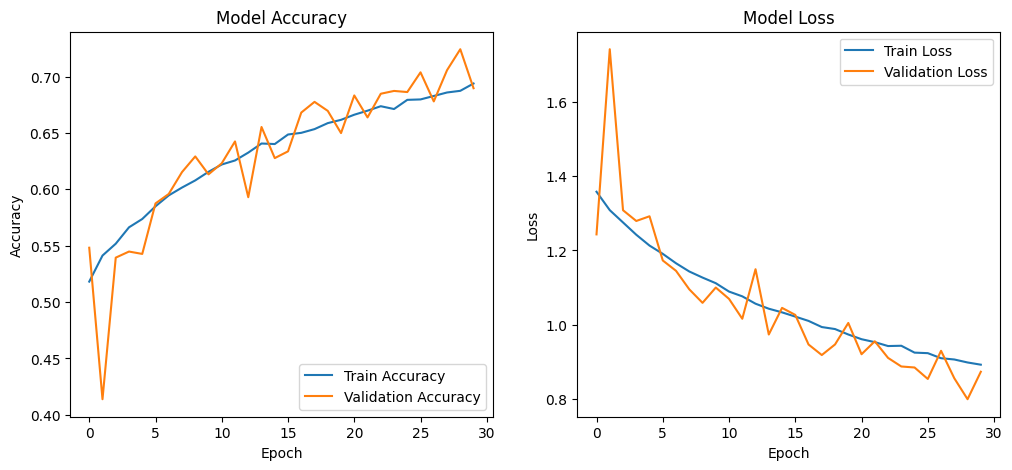

In [25]:
# Define a function to plot the training and validation accuracy and loss over the epochs
def plot_history(history):
  # Create a figure for the plots with a size of 12x5 inches
  plt.figure(figsize=(12, 5))
  # Subplot for accuracy
  plt.subplot(1, 2, 1)
  # Plot training accuracy
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  # Plot validation accuracy
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  # Title for the accuracy plot
  plt.title('Model Accuracy')
  # Label for the y-axis
  plt.ylabel('Accuracy')
  # Label for the x-axis (epochs)
  plt.xlabel('Epoch')
  # Display the legend at the lower right corner
  plt.legend(loc='lower right')
  # Subplot for loss
  plt.subplot(1, 2, 2)
  # Plot training loss
  plt.plot(history.history['loss'], label='Train Loss')
  # Plot validation loss
  plt.plot(history.history['val_loss'], label='Validation Loss')
  # Title for the loss plot
  plt.title('Model Loss')
  # Label for the y-axis
  plt.ylabel('Loss')
  # Label for the x-axis (epochs)
  plt.xlabel('Epoch')
  # Display the legend at the upper right corner
  plt.legend(loc='upper right')
  # Show the plots
  plt.show()
# Call the function to plot the training history
plot_history(history)